<div style='border-bottom: 2px solid mediumblue; padding: 0.5em;'>
    <strong style='color: mediumblue; font-size: 30px;'>CLASSIFICATION.</strong>
    <br>
</div>

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [220]:
df = pd.read_csv('../data/csv/train_dataset/df_clean.csv')

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>1. WORD EMBEDDINGS</strong>
</div>

<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>1.1. Global Vectors</strong>
</div>

To perform embeddings, we chose Global Vectors for Word Representation (GloVe) as it provides pre-trained representations on large corpora, integrating both local and global contextual information.

In [260]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [222]:
try:
    similar_words = glove_vectors.most_similar('cancer', topn=10)
    print("10 words most similar to 'cancer':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'cancer' is not in the vocabulary.")

10 words most similar to 'cancer':
prostate: 0.7622982859611511
breast: 0.730385959148407
cancers: 0.6897203922271729
lung: 0.6681435704231262
leukemia: 0.661848247051239
tumor: 0.6541092395782471
disease: 0.647183358669281
pancreatic: 0.631398618221283
alzheimer: 0.6292967200279236
diagnosed: 0.6266698837280273


To properly perform classification, we need the categories to be represented as integers rather than strings, so we apply Label Encoder to the column.

In [224]:
le = LabelEncoder()

In [225]:
df['category_encoded'] = le.fit_transform(df['category'])

In [226]:
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'association': 0, 'cause': 1, 'complication': 2, 'contraindication': 3, 'diagnosis': 4, 'dosage': 5, 'genetic changes': 6, 'indication': 7, 'information': 8, 'inheritance': 9, 'organization': 10, 'prevention': 11, 'prognosis': 12, 'resources': 13, 'side effects': 14, 'susceptibility': 15, 'symptom': 16, 'tapering': 17, 'treatment': 18}


In [227]:
y = np.array(df['category_encoded'].values, dtype=int) 

Now again, we will tokenize the vectors.

In [228]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['user_query'].values)
sequences = tokenizer.texts_to_sequences(df['user_query'].values)
X = pad_sequences(sequences, maxlen=100)

In [229]:
print('Preprocessed text:', df['user_query'].values[100])
print('\nTokenized text:', sequences[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

Preprocessed text: bone-joint degeneration in the hand or fingers? I notice that the joints or bones in my  hands hurt sharply when working, cooking and lately I have been dropping things from my left hand; even a sudden twist send shock thru my body-What is this?

Tokenized text: [1050, 378, 673, 10, 4, 440, 22, 1242, 1, 624, 19, 4, 1243, 22, 871, 10, 6, 872, 625, 2092, 59, 512, 2093, 2, 2094, 1, 9, 42, 2095, 256, 34, 6, 187, 440, 131, 5, 1239, 2096, 176, 1244, 1062, 6, 120, 20, 7, 15]

Padded text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1050  378
  673   10    4  440   22 1242    1  624   19    4 1243   22  871   10
    6  872  625 2092   59  512 2093    2 2094    1    9   42 2095  256
   34    6  187  440  131    5 1239 2096  176 1244 1062    6  120   

In [230]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.key_to_index:  # Updated to use .key_to_index
        embedding_matrix[i] = glove_vectors.get_vector(word)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       [ 0.038466  , -0.039792  ,  0.082747  , ..., -0.33427   ,
         0.011807  ,  0.059703  ],
       ...,
       [-0.46335   ,  1.18400002,  0.17727   , ..., -0.091061  ,
        -0.20254   ,  0.062091  ],
       [ 0.023112  , -0.24932   ,  0.43187001, ..., -0.15820999,
         0.83003002, -0.56435001],
       [-0.030019  ,  0.47321001, -0.39746001, ..., -0.50011998,
        -0.030466  , -0.012904  ]])

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>2. LSTM</strong>
</div>

We choose LSTM because it efficiently handles long sequences, capturing long-term dependencies in natural language data.
We choose Softmax because it is a multi-class classification problem.

In [231]:
num_categories = len(df['category'].unique())

In [232]:
model_lstm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128),
    Dense(num_categories, activation='softmax')])

model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 300)          1012200   
                                                                 
 lstm_21 (LSTM)              (None, 128)               219648    
                                                                 
 dense_13 (Dense)            (None, 19)                2451      
                                                                 
Total params: 1,234,299
Trainable params: 222,099
Non-trainable params: 1,012,200
_________________________________________________________________


2024-08-05 12:30:47.170023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:30:47.174056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:30:47.176459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [233]:
learning_rate = 0.01 
optimizer = Adam(learning_rate=learning_rate)

In [234]:
model_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X, y, epochs=20, validation_split=0.3)

Epoch 1/20


2024-08-05 12:30:47.762807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:30:47.766529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:30:47.768873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - ETA: 0s - loss: 1.9881 - accuracy: 0.4904

2024-08-05 12:30:52.245563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:30:52.248576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:30:52.250645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 5s 325ms/step - loss: 1.9881 - accuracy: 0.4904 - val_loss: 2.3678 - val_accuracy: 0.3955
Epoch 2/20
10/10 [==============================] - 3s 284ms/step - loss: 1.5825 - accuracy: 0.5353 - val_loss: 2.6070 - val_accuracy: 0.3955
Epoch 3/20
10/10 [==============================] - 2s 247ms/step - loss: 1.3603 - accuracy: 0.5673 - val_loss: 2.5297 - val_accuracy: 0.3881
Epoch 4/20
10/10 [==============================] - 2s 253ms/step - loss: 1.0985 - accuracy: 0.6378 - val_loss: 2.4985 - val_accuracy: 0.3582
Epoch 5/20
10/10 [==============================] - 2s 249ms/step - loss: 0.8390 - accuracy: 0.7212 - val_loss: 3.1798 - val_accuracy: 0.3806
Epoch 6/20
10/10 [==============================] - 3s 278ms/step - loss: 0.6764 - accuracy: 0.7660 - val_loss: 3.0284 - val_accuracy: 0.2985
Epoch 7/20
10/10 [==============================] - 2s 249ms/step - loss: 0.5188 - accuracy: 0.8365 - val_loss: 3.4447 - val_accuracy: 0.3433
Epoch 8/20
10/10 

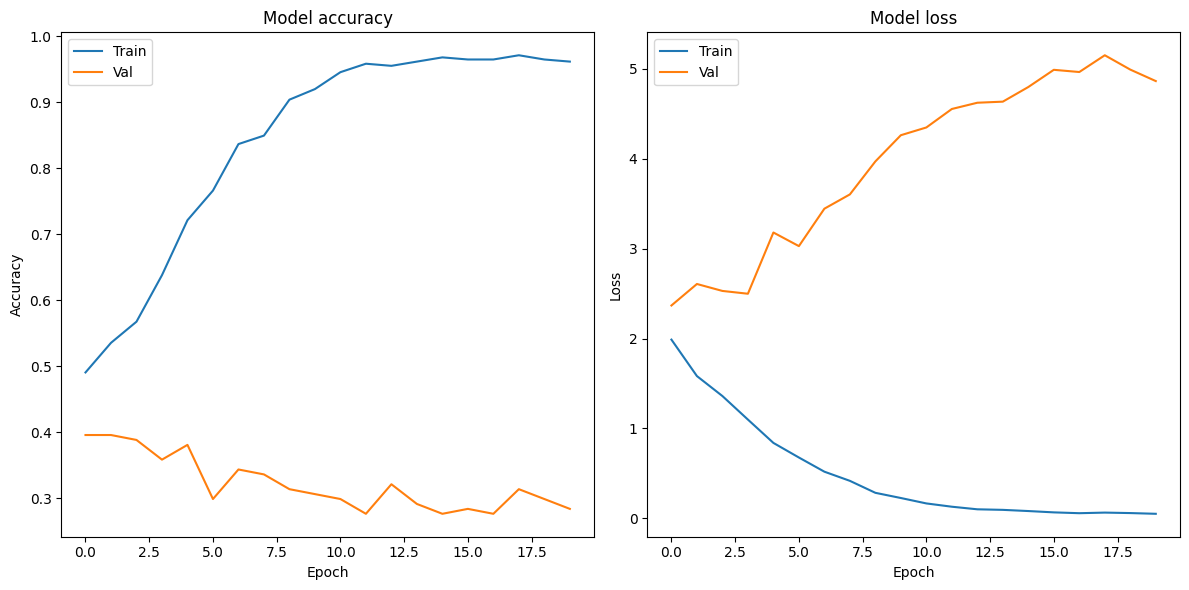

In [235]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [236]:
sequences_query = tokenizer.texts_to_sequences(np.array(["Are large, inoperable schwannomas treatable or able to be shrunk with chemotherapy or radiation?"], dtype=str))
X_query = pad_sequences(sequences_query, maxlen=100)

prediction = model_lstm.predict(X_query)
index_of_max = np.argmax(prediction)
unencoded_prediction = le.inverse_transform(np.array([index_of_max]))[0]
unencoded_prediction

2024-08-05 12:32:12.573744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:32:12.578484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:32:12.583106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 656ms/step


'treatment'

In [237]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

5/5 [==============================] - 0s 77ms/step - loss: 1.5722 - accuracy: 0.7612


In [238]:
accuracy_lstm

0.7611940503120422

Although we see that we have an acceptable accuracy (0.76), the graphs show that our model is not performing correctly, as it fails to classify the validation data properly and does not improve as epochs progress. Additionally, the loss function increases. We will try to optimize the hyperparameters to achieve better metrics.

In [239]:
model_lstm.save('model_lstm_v_1.0.h5')

In [240]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)


<div style="background-color: blanchedalmond; border: 1.5px solid darkorange; border-left: 5px solid darkorange; padding: 0.5em; font-size: 16px">
<strong>Optimization techniques</strong>
</div>

We tested several optimization techniques with different values, but we were unable to achieve a better response from the model.

The techniques used were:

    Dropout
    EarlyStopping

We did not modify the optimizer or learning rate previously used.

We did not apply batch normalization to our model since we chose GloVe, which does not require it.

In [241]:
model_lstm_optim = Sequential()
model_lstm_optim.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300, 
                    input_length=100, weights=[embedding_matrix], trainable=False))
model_lstm_optim.add(LSTM(128, return_sequences=True))
model_lstm_optim.add(Dropout(0.5))
model_lstm_optim.add(LSTM(128))
model_lstm_optim.add(Dropout(0.5))
model_lstm_optim.add(Dense(num_categories, activation='softmax'))

2024-08-05 12:32:14.057198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:32:14.060109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:32:14.067061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [242]:
model_lstm_optim.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [243]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [244]:
history_lstm_optim = model_lstm_optim.fit(X, y, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20


2024-08-05 12:32:15.041968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:32:15.045559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:32:15.047921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - ETA: 0s - loss: 2.6746 - accuracy: 0.2865

2024-08-05 12:32:22.770042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-05 12:32:22.771956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-05 12:32:22.776348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 9s 864ms/step - loss: 2.6746 - accuracy: 0.2865 - val_loss: 2.1694 - val_accuracy: 0.4111
Epoch 2/20
6/6 [==============================] - 4s 661ms/step - loss: 2.0621 - accuracy: 0.4888 - val_loss: 2.0722 - val_accuracy: 0.4111
Epoch 3/20
6/6 [==============================] - 4s 690ms/step - loss: 1.9685 - accuracy: 0.4579 - val_loss: 2.0952 - val_accuracy: 0.4111
Epoch 4/20
6/6 [==============================] - 4s 644ms/step - loss: 1.9499 - accuracy: 0.4831 - val_loss: 2.1233 - val_accuracy: 0.4111
Epoch 5/20
6/6 [==============================] - 4s 638ms/step - loss: 1.9292 - accuracy: 0.4888 - val_loss: 2.1012 - val_accuracy: 0.4111


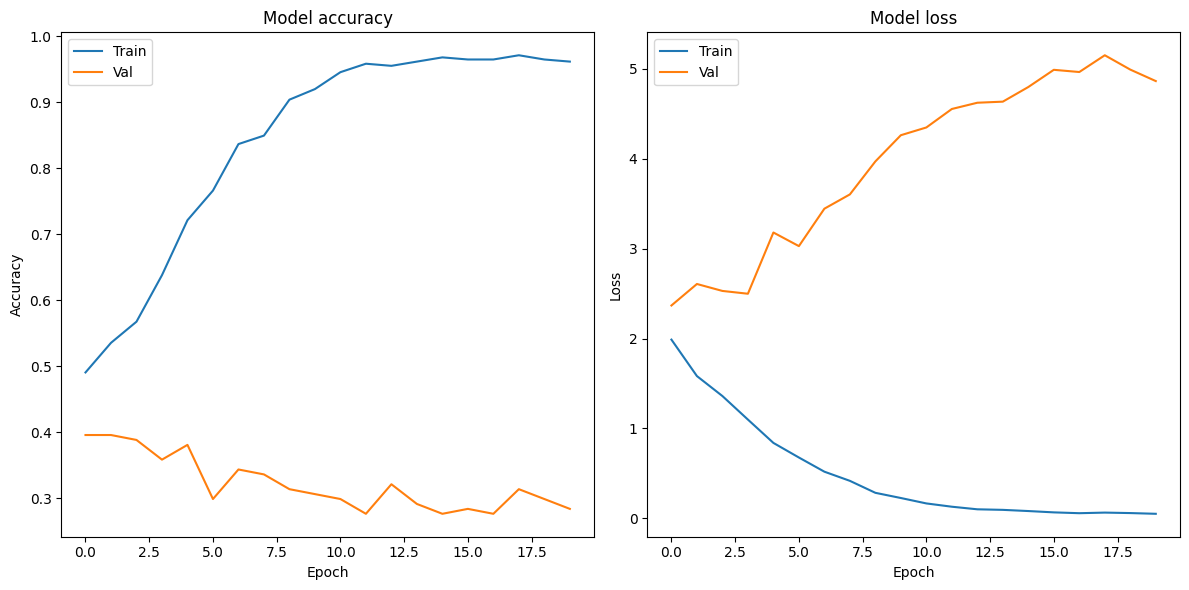

In [245]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [246]:
loss_lstm_optim, accuracy_lstm_optim = model_lstm_optim.evaluate(X_test, y_test)

5/5 [==============================] - 1s 164ms/step - loss: 1.9949 - accuracy: 0.4478


In [247]:
accuracy_lstm_optim

0.447761207818985

Although we varied and tested different hyperparameters, we were unable to optimize the metrics; instead, they worsened.

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>3. XG BOOST</strong>
</div>

Let's explore a different approach. 

We will use a system based on decision trees, specifically XGBoost.

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [256]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [257]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Training Accuracy: 0.9719101123595506
Test Accuracy: 0.3888888888888889


Upon reviewing the accuracy results, we observe considerable overfitting, characterized by excellent performance on the training data but poor results on the test data. We will proceed to analyze the metrics in greater detail.

In [258]:
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train))

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.96      0.96      0.96        27
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         1
           4       1.00      0.92      0.96        12
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.98      0.95      0.96        58
           9       1.00      1.00      1.00         7
          10       0.92      1.00      0.96        12
          11       1.00      1.00      1.00         4
          12       0.92      0.92      0.92        13
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        13
          16       1.00      0.85      0.92       

In [259]:
print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         1
          12       1.00      0.17      0.29         6
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          18       0.47      0.89      0.62        38

    accuracy                           0.39        90
   macro avg       0.11      0.08      0.06        90
weighted avg       0.27      0.39      0.28       

Based on these metrics, we can draw some conclusions:

The model performs excellently on the training set, with accuracy, recall, and F1-score close to 100% for most classes. However, on the test set, performance drops drastically, with an overall accuracy of only 0.39 and very low values for most classes. This is a clear indication of overfitting, where the model has memorized the training data but has not generalized well to new data.

The class that is predicted the best is class 12 (prognosis), which is not among the most common. This suggests that the examples for this class are clear and unambiguous, with questions more focused on this specific response compared to others that may be more general (such as those for diagnosis or information).

In the test set, class 18 (treatment) has a recall of 89%, indicating that the model is capturing most of the examples of this class well. However, precision is 47%, suggesting that the model incorrectly classifies many samples from other classes as class 18. This may be due to it being the most common category by far within our dataset.

Several classes, have zero performance on the test set, meaning the model was unable to correctly predict any instances of these classes. These classes coincide with those that have only one record, so it is logical to assume that they will not be predicted well.
